## This demo is a learning note from this github https://github.com/bentrevett/pytorch-sentiment-analysis/tree/main.

### Learn how to retrain a word embedding using existing word embedding.

Torchtext0.15.1 and Torch2.0.0 are compatible with each other for this demo!!

In [ ]:
!pip install torchtext==0.15.1 --no-cache-dir
!pip install datasets

!pip show torchtext
!pip show torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 235.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 202.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 206.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 354.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 174.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 168.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 198.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:

import io
import os
import re
import shutil
import string
import torch
import torchtext

In [ ]:

from datasets import load_dataset

imdb = load_dataset("imdb")

train_dataset = imdb["train"]
test_dataset = imdb["test"]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
train_dataset[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [ ]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [ ]:
train_dataset, test_dataset

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [ ]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [ ]:
import numpy as np

seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
# tokenization
import torchtext
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [ ]:
def text_tokenizer_example(example, tokenizer, max_length):
  tokens = tokenizer(example["text"])
  tokens = tokens[:max_length] # we only get all the words upto index max_length
  out = {"tokens": tokens}
  return out

In [ ]:
max_length = 256
train_dataset = train_dataset.map(text_tokenizer_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length})

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
test_dataset = test_dataset.map(text_tokenizer_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length})

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [ ]:
# create validation set

ratio =0.25

tra_data = train_dataset.train_test_split(test_size=ratio)
train_dataset = tra_data["train"]
valid_dataset = tra_data['test']

In [ ]:
train_dataset['label'][:20]

[1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]

In [ ]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [ ]:
# build vocabulary

min_freq = 5 # retrive words that appears at least 5 times in the entire dataset
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_dataset["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [ ]:
len(vocab)

21635

In [ ]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [ ]:
# set the default token if words that are not in this vocab
vocab.set_default_index(unk_index)
vocab['some_tokens']

# to look up the indices of some words
vocab.lookup_indices(["hello", "world", "views", "<pad>"])

[5516, 184, 2810, 1]

In [ ]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(18750, 6250, 25000)

In [ ]:
# make sure all datasets have the same features sets and same mapping
# get the token ids for each sample
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}


train_data = train_dataset.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_dataset.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_dataset.map(numericalize_example, fn_kwargs={"vocab": vocab})


Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
print(train_data[0]['ids'][:10])
print(len(train_data[0]['ids']))

[180, 4, 14, 10, 191, 841, 34, 7, 2, 121]
135


In [ ]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [ ]:
vocab.lookup_tokens(train_data[0]["ids"][:10])

['look', ',', 'this', 'is', 'quite', 'possibly', 'one', 'of', 'the', 'best']

In [ ]:
# convert the data into tensors
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [ ]:

import collections
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import tqdm
# the next is to create data loaders, we can get batch samples when training, we also need to do padding
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [ ]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

The model has 6,491,102 trainable parameters


.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
evaluating...: 100%|██████████| 13/13 [00:01<00:00, 12.43it/s]


epoch: 0
train_loss: 0.685, train_acc: 0.604
valid_loss: 0.675, valid_acc: 0.683


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 12.52it/s]


epoch: 1
train_loss: 0.659, train_acc: 0.708
valid_loss: 0.639, valid_acc: 0.723


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 12.59it/s]


epoch: 2
train_loss: 0.608, train_acc: 0.750
valid_loss: 0.583, valid_acc: 0.752


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 10.75it/s]


epoch: 3
train_loss: 0.540, train_acc: 0.791
valid_loss: 0.516, valid_acc: 0.802


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 12.26it/s]


epoch: 4
train_loss: 0.470, train_acc: 0.834
valid_loss: 0.457, valid_acc: 0.832


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 12.11it/s]


epoch: 5
train_loss: 0.409, train_acc: 0.863
valid_loss: 0.414, valid_acc: 0.846


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 12.07it/s]


epoch: 6
train_loss: 0.361, train_acc: 0.880
valid_loss: 0.379, valid_acc: 0.862


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


epoch: 7
train_loss: 0.324, train_acc: 0.893
valid_loss: 0.356, valid_acc: 0.867


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 12.03it/s]


epoch: 8
train_loss: 0.293, train_acc: 0.903
valid_loss: 0.337, valid_acc: 0.873


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 12.27it/s]


epoch: 9
train_loss: 0.269, train_acc: 0.912
valid_loss: 0.324, valid_acc: 0.877


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 12.22it/s]


epoch: 10
train_loss: 0.248, train_acc: 0.921
valid_loss: 0.313, valid_acc: 0.878


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 10.13it/s]


epoch: 11
train_loss: 0.230, train_acc: 0.927
valid_loss: 0.305, valid_acc: 0.881


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 12.23it/s]


epoch: 12
train_loss: 0.214, train_acc: 0.933
valid_loss: 0.299, valid_acc: 0.884


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 12.36it/s]


epoch: 13
train_loss: 0.199, train_acc: 0.939
valid_loss: 0.296, valid_acc: 0.885


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 12.09it/s]


epoch: 14
train_loss: 0.186, train_acc: 0.945
valid_loss: 0.290, valid_acc: 0.887


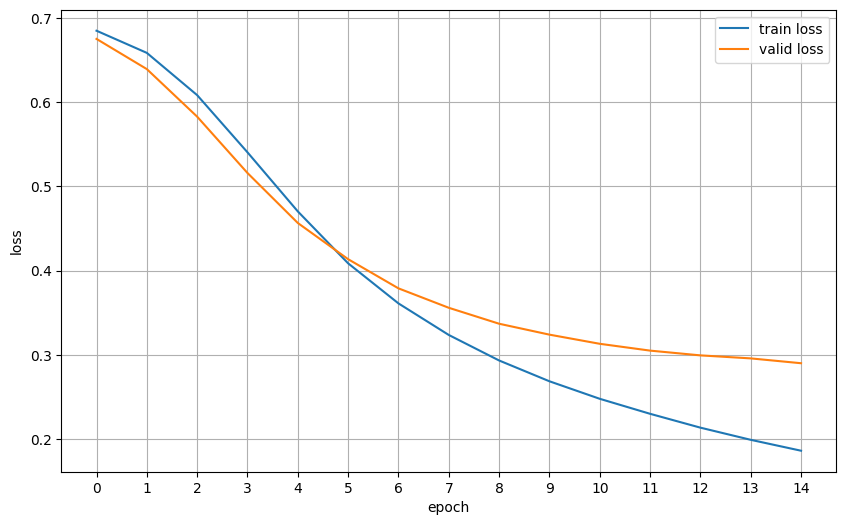

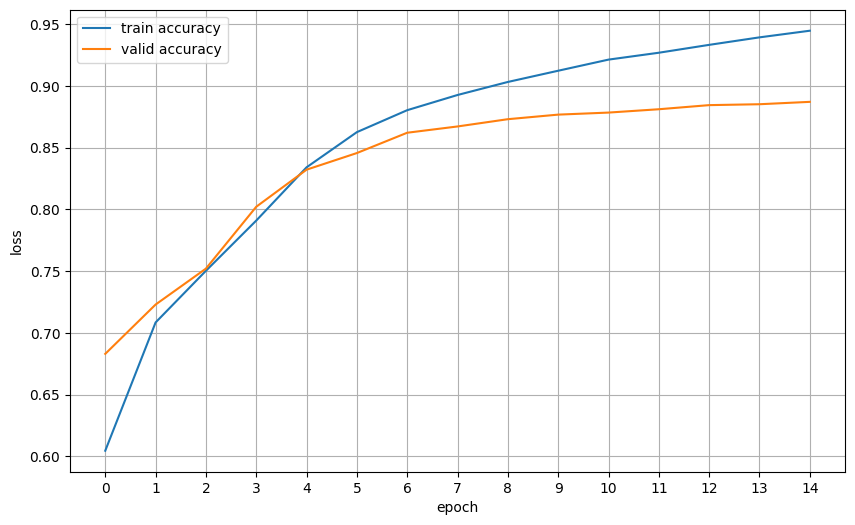

In [ ]:
# build model
class BoWClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embed_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, ids):
        embedded = self.embedding(ids)
        # print(embedded.shape, 'here 1')
        pooled = embedded.mean(dim=1) # if each data point has only 1 word, i.e. the seq length =1, we dont need this
        # print(pooled.shape, 'here 2')
        pooled = self.relu(pooled) # use relu
        prediction = self.fc(pooled)
        return prediction



vocab_size = len(vocab)
embedding_dim = 300
output_dim = len(train_data.unique("label"))

model = BoWClassifier(vocab_size, embedding_dim, output_dim, pad_index)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

# use existing word embedding as the start points
vectors = torchtext.vocab.GloVe(name="6B", dim="300")


vectors.get_vecs_by_tokens(["hello", "<pad>"])


pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
pretrained_embedding.shape


model.embedding.weight.data = pretrained_embedding


optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# this is to move tensor to device to speed up
model = model.to(device)
criterion = criterion.to(device)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy


def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    # torch.no_grad() is a context manager in PyTorch that disables gradient calculations.
    # It's used when you want to perform operations without tracking gradients,
    # which can be useful for inference or when you're sure you won't need to call backward() on the resulting tensors.
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        # print(ids.shape, 'id shape')
        # print(label.shape, 'label shape')
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad() # clean up gradient
        loss.backward() # doing backward
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


# train the model

# optimizer.zero_grad()is a method in PyTorch used to reset the gradients of all optimized tensors to zero before each training iteration.
# By default, gradients in PyTorch accumulate with each backward pass.
# Failing to clear them would cause the optimizer to use the accumulated gradients from previous iterations,
# leading to incorrect updates of the model's parameters and hindering the training process.
# It is called before loss.backward() and optimizer.step()
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        # print(ids.shape, 'id shape')
        # print(label.shape, 'label shape')
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad() # clean up gradient
        loss.backward() # doing backward
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)



n_epochs = 15
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

# plots
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [ ]:
## this is toy example to learn about embedding's dimension
# import torch
# import torch.nn as nn
# # Define embedding layer
# embedding_dim = 10 # Size of each embedding vector
# num_embeddings = 100 # Number of embeddings (e.g., vocabulary size)
# embedding = nn.Embedding(num_embeddings, embedding_dim)

# # Example batch of input indices
# batch_size = 3
# seq_length = 5
# input_indices = torch.randint(0, num_embeddings, (batch_size, seq_length))
# print(input_indices, 'input_indices')
# # Get embeddings for the batch
# batch_embeddings = embedding(input_indices)
# print(batch_embeddings.shape) # Output: torch.Size([3, 5, 100]
# # Calculate the mean embedding for each sequence in the batch
# mean_embeddings = torch.mean(batch_embeddings, dim=1)
# # Print the shape of the mean embeddings
# print(mean_embeddings.shape, 'mean embedding shape') # Output: torch.Size([3, 100])

# # Print the mean embeddings
# print(mean_embeddings)

In [ ]:
# print all parameters
for param in model.parameters():
    print(param.requires_grad)

# if we want to freeze some parameters of the model
# for param in some_model_layer.parameters():
#     param.requires_grad_(False)

# or for the entire model
# for param in model.parameters():
#     param.requires_grad_(False)

True
True
True


In [ ]:
hello_vector = vectors.get_vecs_by_tokens("hello")
hello_vector.shape

torch.Size([300])

In [ ]:
model.embedding.weight

Parameter containing:
tensor([[ 0.0611,  0.1522,  0.0224,  ...,  0.3093,  0.0127, -0.0057],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1557,  0.2602,  0.1194,  ...,  0.2561, -0.1870,  0.0631],
        ...,
        [ 0.3934, -0.7854, -0.0215,  ..., -0.1083,  0.6774, -0.1414],
        [ 0.3478,  0.1531, -0.1804,  ..., -0.0443,  0.4599,  0.2077],
        [-0.1583, -0.0202, -0.3835,  ..., -0.5413,  0.3303, -0.0227]],
       requires_grad=True)

In [ ]:
pretrained_embedding[3][:10]

tensor([-0.1054,  0.1082,  0.2442, -0.1381,  0.2110,  0.2675, -0.1140,  0.3741,
         0.4763, -1.6785])

In [ ]:
# prompt: given the model, predict a new text

import torch

# Load the saved model
vocab_size = len(vocab)
embedding_dim = 300
output_dim = len(train_data.unique("label"))
model = BoWClassifier(vocab_size, embedding_dim, output_dim, pad_index)
model.load_state_dict(torch.load("nbow.pt"))
model.eval()  # Set the model to evaluation mode

# Example new text
new_text = "This movie is great!"

# Tokenize and numericalize the new text
tokens = tokenizer(new_text)
ids = vocab.lookup_indices(tokens)
ids_tensor = torch.tensor(ids).unsqueeze(0)  # Add a batch dimension

# Make the prediction
with torch.no_grad():
  prediction = model(ids_tensor.to(device))
  predicted_class = prediction.argmax(dim=-1).item()

# Print the prediction
print(f"Predicted class: {predicted_class}")

if predicted_class == 1:
    print("Positive sentiment")
else:
    print("Negative sentiment")



test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")



Predicted class: 1
Positive sentiment


evaluating...: 100%|██████████| 49/49 [00:04<00:00, 11.42it/s]

test_loss: 0.328, test_acc: 0.866


In [ ]:
txt = 'I like this movie! this movie is fantastic'
res = predict_sentiment(txt, model, tokenizer, vocab, device)
print(res)

text = "This film is terrible!"
res = predict_sentiment(text, model, tokenizer, vocab, device)
print(res)

txt = "This movie was absolutely fantastic!"
res = predict_sentiment(txt, model, tokenizer, vocab, device)
print(res)


text = "This film is great!"
res = predict_sentiment(text, model, tokenizer, vocab, device)
print(res)

(1, 0.9996628761291504)
(0, 0.9999921321868896)
(1, 0.9994545578956604)
(1, 1.0)


In [ ]:
# check the embeddings after training
model.embedding.weight.data[3]

tensor([-1.0536e-01,  1.0818e-01,  2.4416e-01, -1.3812e-01,  2.1099e-01,
         2.6753e-01, -1.1400e-01,  3.7406e-01,  4.7630e-01, -1.6785e+00,
         1.4851e-01,  2.3822e-01,  1.9368e-01,  2.5664e-01,  2.9566e-01,
         1.2458e-01, -2.6379e-01,  3.5992e-01, -6.8401e-02,  1.2459e-01,
         1.5709e-01,  1.3838e-01,  3.8229e-01, -1.3601e-01, -2.1219e-01,
        -6.1459e-03, -1.0457e-01,  3.4483e-01,  4.2999e-02,  8.8399e-02,
         1.4417e-01,  2.5231e-01, -1.0456e-01,  8.9489e-02, -7.1742e-01,
         7.8751e-03,  1.8082e-01,  3.8076e-01,  1.7930e-01,  3.7628e-01,
         2.5273e-01, -1.0092e-01,  8.0746e-02,  2.5004e-01,  6.0327e-02,
         4.8313e-02,  3.1728e-01,  4.1331e-01,  3.3666e-01,  3.4006e-01,
        -1.3786e-01, -6.5499e-02,  5.5792e-02, -7.4871e-03,  2.3506e-01,
         8.9323e-02, -2.6684e-01,  2.6256e-01,  9.8292e-04, -1.4081e-01,
         2.4370e-01,  8.9951e-02, -2.8253e-02, -2.5858e-02,  1.2337e-01,
        -5.5397e-01,  4.5289e-01,  6.1436e-02,  2.9

In [ ]:
word = 'woman'
word_indice = vocab[word]
word_indices = torch.LongTensor([word_indice])
word_embedding = model.embedding(word_indices)
print(word_embedding)


tensor([[-4.9522e-01,  5.4236e-02, -5.0393e-01, -1.3133e-01,  1.2256e-02,
         -1.0218e-01, -3.1242e-01, -2.3171e-01, -8.9845e-02, -1.1338e+00,
          3.6012e-02, -5.7678e-02, -1.1260e-03, -2.0130e-01,  1.0831e-02,
          1.0961e-01,  8.9021e-02, -2.3213e-01, -5.5097e-01, -4.8091e-01,
         -3.5099e-01,  2.5086e-01,  1.0650e-01,  3.7629e-02, -3.3095e-01,
         -3.4358e-01,  1.9771e-01, -1.5489e-01,  2.0999e-01,  6.7946e-02,
         -6.3542e-01,  4.3214e-01, -3.3779e-01, -3.8021e-01, -8.0202e-01,
          6.1406e-01, -4.6447e-01, -7.2326e-03,  3.4433e-01,  7.3681e-01,
          8.3443e-01, -3.1540e-01, -1.1676e-01,  1.4687e-01, -2.2914e-01,
         -3.3989e-02,  3.3492e-01,  2.3222e-02, -2.5950e-01,  4.1223e-01,
         -1.8176e-01,  1.6091e-01,  2.1371e-01, -1.3432e-02, -5.5050e-01,
         -2.1122e-01,  1.4358e-01, -3.3444e-01,  4.5205e-01, -3.3141e-01,
          1.2067e-01,  4.1253e-02,  4.6401e-01,  2.7334e-01, -6.3929e-01,
         -6.4595e-01, -7.2181e-02, -2.

In [ ]:


import torch

# Assuming 'model' and 'vocab' are defined from the previous code
# and 'model.embedding.weight.data' holds the word embeddings.

word = 'women'
word_indice = vocab[word]

unk_index = vocab["<unk>"]

# Find the closest word in the vocabulary based on cosine similarity
if word_indice != unk_index: # if word exist
    word_embedding = model.embedding(torch.LongTensor([word_indice]))
    cosine_similarities = torch.nn.functional.cosine_similarity(word_embedding, model.embedding.weight.data)

    # Find the index of the most similar word (excluding the word itself)
    most_similar_index = torch.argsort(cosine_similarities, descending=True)[1]  # [1] to exclude itself

    most_similar_word = vocab.get_itos()[most_similar_index]
    print(f"The most similar word to '{word}' is '{most_similar_word}'")
else:
    print(f"'{word}' not in vocabulary.")


The most similar word to 'women' is 'men'


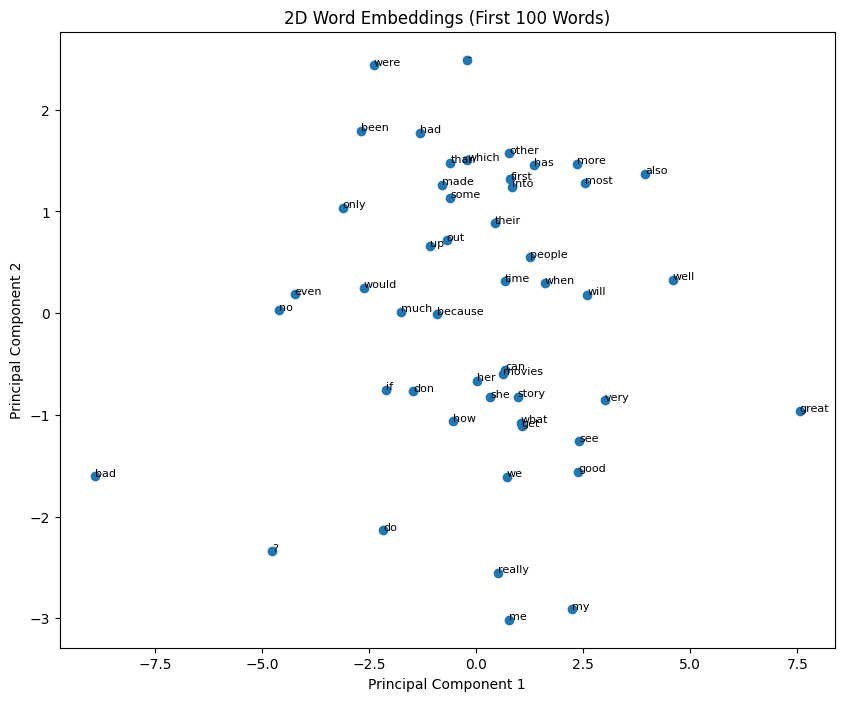

In [ ]:
# prompt: plot the first 100 words embedding after decrease the dimension to 2

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'model' and 'vocab' are defined from the previous code
# and 'model.embedding.weight.data' holds the word embeddings.

# Get the first 100 word embeddings
embeddings = model.embedding.weight.data[50:100]

# Reduce dimensions to 2 using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings.cpu().numpy())

# Get the corresponding words
words = vocab.get_itos()[50:100]

# Create the plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Add labels for each point
for i, word in enumerate(words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

plt.title("2D Word Embeddings (First 100 Words)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


The model has 2,163,702 trainable parameters


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 38.28it/s]


epoch: 0
train_loss: 0.690, train_acc: 0.539
valid_loss: 0.686, valid_acc: 0.627


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 41.04it/s]


epoch: 1
train_loss: 0.681, train_acc: 0.643
valid_loss: 0.674, valid_acc: 0.681


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 38.43it/s]


epoch: 2
train_loss: 0.665, train_acc: 0.698
valid_loss: 0.654, valid_acc: 0.720


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 40.49it/s]


epoch: 3
train_loss: 0.638, train_acc: 0.730
valid_loss: 0.626, valid_acc: 0.737


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 40.13it/s]


epoch: 4
train_loss: 0.605, train_acc: 0.755
valid_loss: 0.592, valid_acc: 0.757


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 42.07it/s]


epoch: 5
train_loss: 0.566, train_acc: 0.779
valid_loss: 0.556, valid_acc: 0.780


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 37.80it/s]


epoch: 6
train_loss: 0.527, train_acc: 0.804
valid_loss: 0.519, valid_acc: 0.803


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 39.62it/s]


epoch: 7
train_loss: 0.488, train_acc: 0.827
valid_loss: 0.486, valid_acc: 0.821


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 26.83it/s]


epoch: 8
train_loss: 0.452, train_acc: 0.845
valid_loss: 0.456, valid_acc: 0.834


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 38.70it/s]


epoch: 9
train_loss: 0.419, train_acc: 0.859
valid_loss: 0.431, valid_acc: 0.842


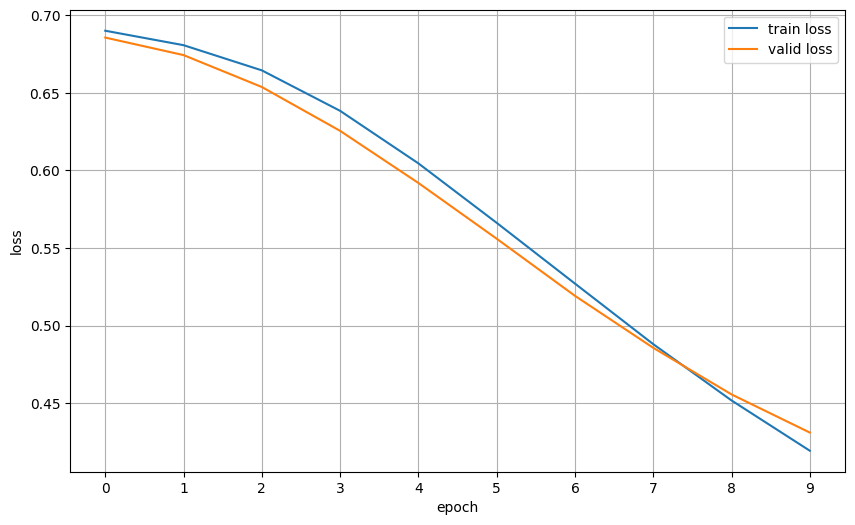

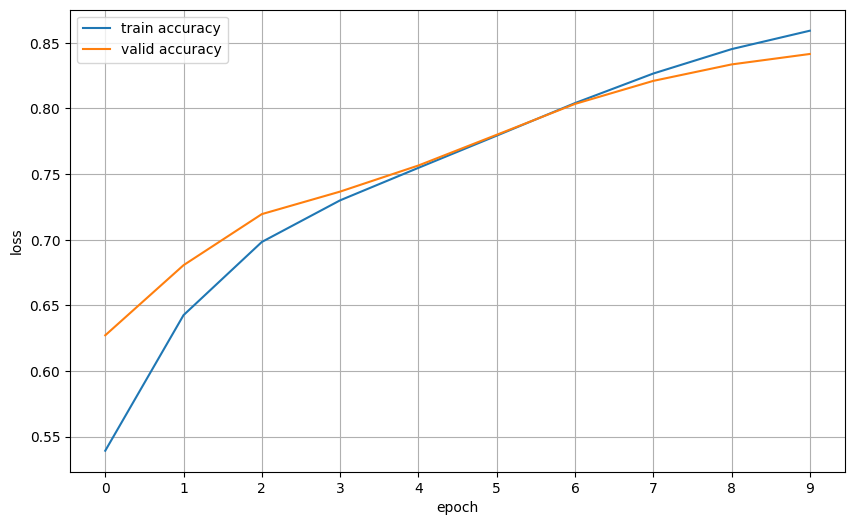

In [ ]:
# if I use embedding dimension of 100 and epoch of 10, it generates some interesting results.
# with 0.01 as the learning rate

# build model
class BoWClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embed_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, ids):
        embedded = self.embedding(ids)
        # print(embedded.shape, 'here 1')
        pooled = embedded.mean(dim=1) # if each data point has only 1 word, i.e. the seq length =1, we dont need this
        # print(pooled.shape, 'here 2')
        pooled = self.relu(pooled) # use relu
        prediction = self.fc(pooled)
        return prediction



vocab_size = len(vocab)
embedding_dim = 100
output_dim = len(train_data.unique("label"))

model = BoWClassifier(vocab_size, embedding_dim, output_dim, pad_index)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

# use existing word embedding as the start points
vectors = torchtext.vocab.GloVe(name="6B", dim="100")


vectors.get_vecs_by_tokens(["hello", "<pad>"])


pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
pretrained_embedding.shape


model.embedding.weight.data = pretrained_embedding


optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# this is to move tensor to device to speed up
model = model.to(device)
criterion = criterion.to(device)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy


def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    # torch.no_grad() is a context manager in PyTorch that disables gradient calculations.
    # It's used when you want to perform operations without tracking gradients,
    # which can be useful for inference or when you're sure you won't need to call backward() on the resulting tensors.
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        # print(ids.shape, 'id shape')
        # print(label.shape, 'label shape')
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad() # clean up gradient
        loss.backward() # doing backward
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


# train the model

# optimizer.zero_grad()is a method in PyTorch used to reset the gradients of all optimized tensors to zero before each training iteration.
# By default, gradients in PyTorch accumulate with each backward pass.
# Failing to clear them would cause the optimizer to use the accumulated gradients from previous iterations,
# leading to incorrect updates of the model's parameters and hindering the training process.
# It is called before loss.backward() and optimizer.step()
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        # print(ids.shape, 'id shape')
        # print(label.shape, 'label shape')
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad() # clean up gradient
        loss.backward() # doing backward
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)



n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow1.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

# plots
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

The model has 2,163,702 trainable parameters


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 39.30it/s]


epoch: 0
train_loss: 0.492, train_acc: 0.744
valid_loss: 0.317, valid_acc: 0.872


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 37.53it/s]


epoch: 1
train_loss: 0.183, train_acc: 0.933
valid_loss: 0.304, valid_acc: 0.884


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 38.35it/s]


epoch: 2
train_loss: 0.085, train_acc: 0.975
valid_loss: 0.361, valid_acc: 0.877


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 36.55it/s]


epoch: 3
train_loss: 0.038, train_acc: 0.991
valid_loss: 0.444, valid_acc: 0.870


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 40.03it/s]


epoch: 4
train_loss: 0.018, train_acc: 0.998
valid_loss: 0.490, valid_acc: 0.869


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 39.24it/s]


epoch: 5
train_loss: 0.008, train_acc: 0.999
valid_loss: 0.536, valid_acc: 0.868


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 38.01it/s]


epoch: 6
train_loss: 0.004, train_acc: 1.000
valid_loss: 0.575, valid_acc: 0.867


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 36.40it/s]


epoch: 7
train_loss: 0.002, train_acc: 1.000
valid_loss: 0.600, valid_acc: 0.868


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 36.96it/s]


epoch: 8
train_loss: 0.002, train_acc: 1.000
valid_loss: 0.622, valid_acc: 0.868


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 35.89it/s]


epoch: 9
train_loss: 0.001, train_acc: 1.000
valid_loss: 0.641, valid_acc: 0.870


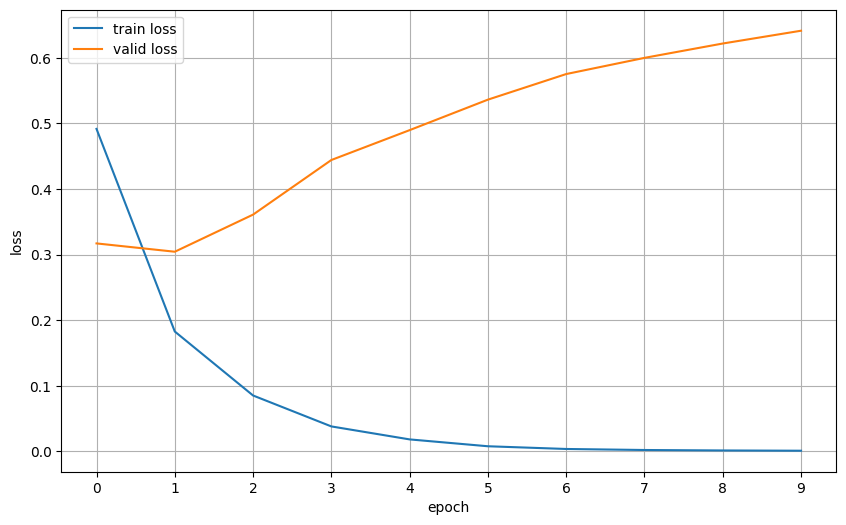

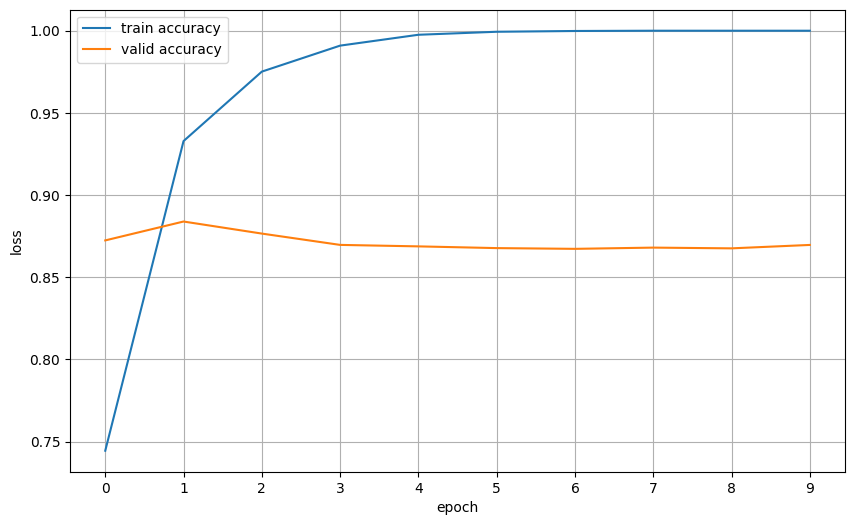

In [ ]:
# if I use embedding dimension of 100 and epoch of 10, it generates some interesting results.
# with a higher learning rate 0.1

# build model
class BoWClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embed_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, ids):
        embedded = self.embedding(ids)
        # print(embedded.shape, 'here 1')
        pooled = embedded.mean(dim=1) # if each data point has only 1 word, i.e. the seq length =1, we dont need this
        # print(pooled.shape, 'here 2')
        pooled = self.relu(pooled) # use relu
        prediction = self.fc(pooled)
        return prediction



vocab_size = len(vocab)
embedding_dim = 100
output_dim = len(train_data.unique("label"))

model = BoWClassifier(vocab_size, embedding_dim, output_dim, pad_index)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

# use existing word embedding as the start points
vectors = torchtext.vocab.GloVe(name="6B", dim="100")


vectors.get_vecs_by_tokens(["hello", "<pad>"])


pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
pretrained_embedding.shape


model.embedding.weight.data = pretrained_embedding


optimizer = optim.Adam(model.parameters(),lr=0.1)
# if I change the lr to 0.1, it is likely that the loss is a flat line for valid dataset
# since it is overfitting to the training data
# and Large weight updates (higher learning rate) may push the neuron's activation permanently
# into the negative region. Since the ReLU function outputs zero for any negative value and its derivative is also zero
#  in that range,
# the neuron stops contributing to learning because it no longer receives meaningful gradient updates.
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# this is to move tensor to device to speed up
model = model.to(device)
criterion = criterion.to(device)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy


def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    # torch.no_grad() is a context manager in PyTorch that disables gradient calculations.
    # It's used when you want to perform operations without tracking gradients,
    # which can be useful for inference or when you're sure you won't need to call backward() on the resulting tensors.
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        # print(ids.shape, 'id shape')
        # print(label.shape, 'label shape')
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad() # clean up gradient
        loss.backward() # doing backward
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


# train the model

# optimizer.zero_grad()is a method in PyTorch used to reset the gradients of all optimized tensors to zero before each training iteration.
# By default, gradients in PyTorch accumulate with each backward pass.
# Failing to clear them would cause the optimizer to use the accumulated gradients from previous iterations,
# leading to incorrect updates of the model's parameters and hindering the training process.
# It is called before loss.backward() and optimizer.step()
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        # print(ids.shape, 'id shape')
        # print(label.shape, 'label shape')
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad() # clean up gradient
        loss.backward() # doing backward
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)



n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow2.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

# plots
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

The model has 2,163,702 trainable parameters


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 38.10it/s]


epoch: 0
train_loss: 0.691, train_acc: 0.556
valid_loss: 0.687, valid_acc: 0.652


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 37.65it/s]


epoch: 1
train_loss: 0.682, train_acc: 0.620
valid_loss: 0.677, valid_acc: 0.619


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 37.32it/s]


epoch: 2
train_loss: 0.668, train_acc: 0.690
valid_loss: 0.659, valid_acc: 0.684


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 36.05it/s]


epoch: 3
train_loss: 0.643, train_acc: 0.721
valid_loss: 0.632, valid_acc: 0.726


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 34.27it/s]


epoch: 4
train_loss: 0.613, train_acc: 0.748
valid_loss: 0.601, valid_acc: 0.743


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 40.12it/s]


epoch: 5
train_loss: 0.576, train_acc: 0.773
valid_loss: 0.564, valid_acc: 0.777


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 35.96it/s]


epoch: 6
train_loss: 0.536, train_acc: 0.799
valid_loss: 0.527, valid_acc: 0.794


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 26.67it/s]


epoch: 7
train_loss: 0.494, train_acc: 0.823
valid_loss: 0.490, valid_acc: 0.819


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 36.18it/s]


epoch: 8
train_loss: 0.455, train_acc: 0.844
valid_loss: 0.459, valid_acc: 0.831


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 37.06it/s]


epoch: 9
train_loss: 0.420, train_acc: 0.860
valid_loss: 0.431, valid_acc: 0.843


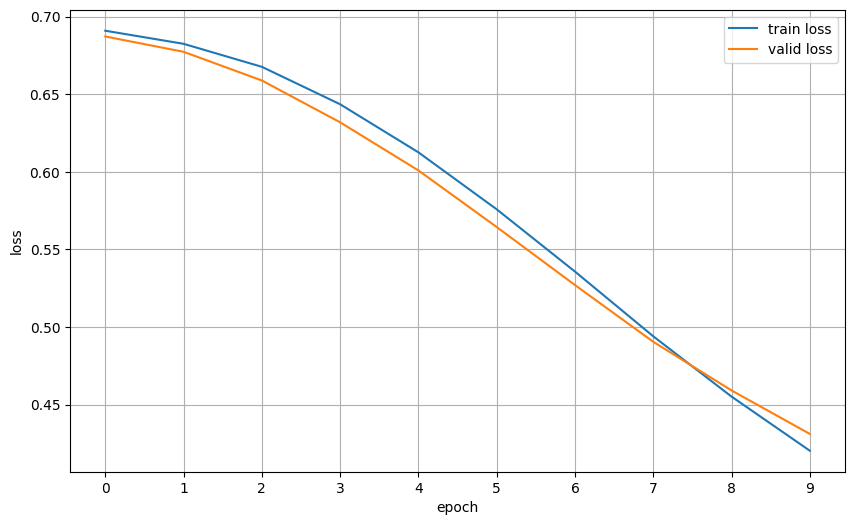

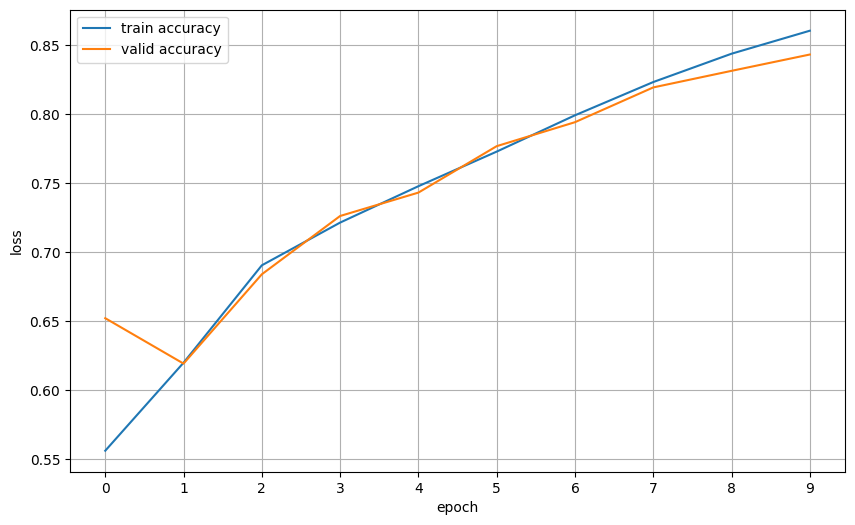

In [ ]:
# if I use embedding dimension of 100 and epoch of 10, it generates some interesting results.
# with a higher learning rate 0.1
# with a leaky relu

# build model
class BoWClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embed_dim, output_dim)
        self.relu = nn.LeakyReLU()

    def forward(self, ids):
        embedded = self.embedding(ids)
        # print(embedded.shape, 'here 1')
        pooled = embedded.mean(dim=1) # if each data point has only 1 word, i.e. the seq length =1, we dont need this
        # print(pooled.shape, 'here 2')
        pooled = self.relu(pooled) # use relu
        prediction = self.fc(pooled)
        return prediction



vocab_size = len(vocab)
embedding_dim = 100
output_dim = len(train_data.unique("label"))

model = BoWClassifier(vocab_size, embedding_dim, output_dim, pad_index)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

# use existing word embedding as the start points
vectors = torchtext.vocab.GloVe(name="6B", dim="100")


vectors.get_vecs_by_tokens(["hello", "<pad>"])


pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
pretrained_embedding.shape


model.embedding.weight.data = pretrained_embedding


optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# this is to move tensor to device to speed up
model = model.to(device)
criterion = criterion.to(device)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy


def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    # torch.no_grad() is a context manager in PyTorch that disables gradient calculations.
    # It's used when you want to perform operations without tracking gradients,
    # which can be useful for inference or when you're sure you won't need to call backward() on the resulting tensors.
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        # print(ids.shape, 'id shape')
        # print(label.shape, 'label shape')
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad() # clean up gradient
        loss.backward() # doing backward
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


# train the model

# optimizer.zero_grad()is a method in PyTorch used to reset the gradients of all optimized tensors to zero before each training iteration.
# By default, gradients in PyTorch accumulate with each backward pass.
# Failing to clear them would cause the optimizer to use the accumulated gradients from previous iterations,
# leading to incorrect updates of the model's parameters and hindering the training process.
# It is called before loss.backward() and optimizer.step()
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        # print(ids.shape, 'id shape')
        # print(label.shape, 'label shape')
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad() # clean up gradient
        loss.backward() # doing backward
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)



n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow3.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

# plots
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

The model has 2,163,702 trainable parameters


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 38.34it/s]


epoch: 0
train_loss: 0.688, train_acc: 0.557
valid_loss: 0.681, valid_acc: 0.574


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 27.09it/s]


epoch: 1
train_loss: 0.678, train_acc: 0.581
valid_loss: 0.670, valid_acc: 0.624


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 39.11it/s]


epoch: 2
train_loss: 0.667, train_acc: 0.629
valid_loss: 0.661, valid_acc: 0.636


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 36.51it/s]


epoch: 3
train_loss: 0.660, train_acc: 0.630
valid_loss: 0.653, valid_acc: 0.651


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 37.00it/s]


epoch: 4
train_loss: 0.651, train_acc: 0.644
valid_loss: 0.647, valid_acc: 0.649


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 25.26it/s]


epoch: 5
train_loss: 0.644, train_acc: 0.655
valid_loss: 0.639, valid_acc: 0.655


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 36.16it/s]


epoch: 6
train_loss: 0.639, train_acc: 0.654
valid_loss: 0.631, valid_acc: 0.669


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 39.48it/s]


epoch: 7
train_loss: 0.631, train_acc: 0.666
valid_loss: 0.624, valid_acc: 0.673


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 37.77it/s]


epoch: 8
train_loss: 0.624, train_acc: 0.672
valid_loss: 0.617, valid_acc: 0.683


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 37.11it/s]


epoch: 9
train_loss: 0.618, train_acc: 0.679
valid_loss: 0.615, valid_acc: 0.678


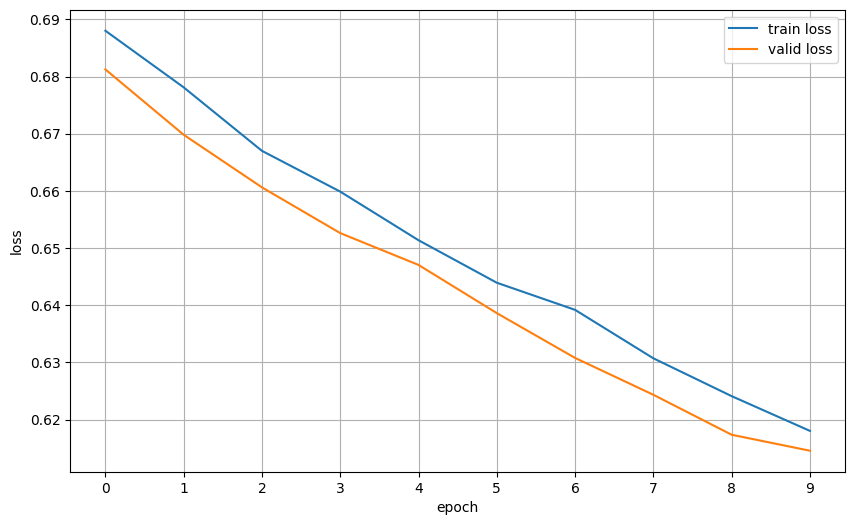

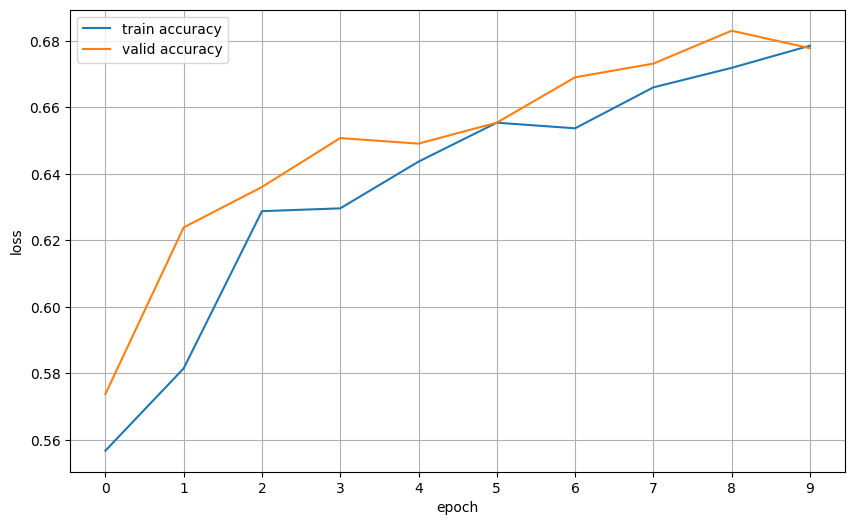

In [ ]:
# if I use embedding dimension of 100 and epoch of 10, it generates some interesting results.
# with a higher learning rate 0.1, with moment of SGD optimizer
# with a leaky relu

# build model
class BoWClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embed_dim, output_dim)
        self.relu = nn.LeakyReLU()

    def forward(self, ids):
        embedded = self.embedding(ids)
        # print(embedded.shape, 'here 1')
        pooled = embedded.mean(dim=1) # if each data point has only 1 word, i.e. the seq length =1, we dont need this
        # print(pooled.shape, 'here 2')
        pooled = self.relu(pooled) # use relu
        prediction = self.fc(pooled)
        return prediction



vocab_size = len(vocab)
embedding_dim = 100
output_dim = len(train_data.unique("label"))

model = BoWClassifier(vocab_size, embedding_dim, output_dim, pad_index)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

# use existing word embedding as the start points
# vectors = torchtext.vocab.GloVe(name="6B", dim="100")


vectors.get_vecs_by_tokens(["hello", "<pad>"])


pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
pretrained_embedding.shape


model.embedding.weight.data = pretrained_embedding


# optimizer = optim.Adam(model.parameters())

# # SGD with momentum instead of Adam
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# this is to move tensor to device to speed up
model = model.to(device)
criterion = criterion.to(device)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy


def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    # torch.no_grad() is a context manager in PyTorch that disables gradient calculations.
    # It's used when you want to perform operations without tracking gradients,
    # which can be useful for inference or when you're sure you won't need to call backward() on the resulting tensors.
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        # print(ids.shape, 'id shape')
        # print(label.shape, 'label shape')
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad() # clean up gradient
        loss.backward() # doing backward
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


# train the model

# optimizer.zero_grad()is a method in PyTorch used to reset the gradients of all optimized tensors to zero before each training iteration.
# By default, gradients in PyTorch accumulate with each backward pass.
# Failing to clear them would cause the optimizer to use the accumulated gradients from previous iterations,
# leading to incorrect updates of the model's parameters and hindering the training process.
# It is called before loss.backward() and optimizer.step()
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        # print(ids.shape, 'id shape')
        # print(label.shape, 'label shape')
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad() # clean up gradient
        loss.backward() # doing backward
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)



n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow4.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

# plots
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

